In [3]:
#Implicit_opt

In [4]:
import sys
sys.path.append("..")
from geomatry.opt.scipy_optimizer import SingleSystemOptimizer
from geomatry.opt_Energy_approximated.optimizer import SingleSystemOptimizer as SingleSystemOptimizer_Energy
from geomatry.opt.loss import rmsd_loss
from geomatry.ff.graph import get_given_graph_builder
from geomatry.ff.LennardJones import LennardJonesFF, _random_lj_system, _random_lj_ff_param
import torch
import copy

N = 50
N_pairs = 200
max_Za = 3
Ra, Za, idx_i, idx_j = _random_lj_system(N, N_pairs, max_Za, start_Za=1)
k, r0 = _random_lj_ff_param(max_Za, r0_max=5, k_max=5)
ff = LennardJonesFF(max_Za)
ff.reset_parameters(k, r0)

fixed_atom_indices = [0,1,2]
graph_builder = get_given_graph_builder(idx_i, idx_j)

# start implicit optimization
params_star = ff.state_dict()
print("params_star", params_star)
optimizer = SingleSystemOptimizer(
    Ra, Za, graph_builder, ff, rmsd_loss, 
    params_star=params_star,
    fixed_atom_indices=fixed_atom_indices,
    fmax=1e-5
)

optimizer_Energy = SingleSystemOptimizer_Energy(
    Ra, Za, graph_builder, ff, rmsd_loss, 
    params_star=params_star,
    fixed_atom_indices=fixed_atom_indices,
    fmax=1e-5
)


k_perturbed = torch.clamp(k.clone() + 0.001 * torch.randn_like(k), min=0)
r0_perturbed = torch.clamp(r0.clone() + 0.001 * torch.randn_like(r0), min=0)
ff.reset_parameters(k_perturbed, r0_perturbed)
params_0 = ff.state_dict()
params_0_old = copy.deepcopy(params_0)
print("params_0", params_0)
new_params_0=optimizer.optimize(params_0)
print("params_optimized",new_params_0)

params_star OrderedDict([('k', tensor([[4.1152, 1.6829, 1.0213, 1.6490],
        [1.6829, 0.8589, 3.4642, 1.3810],
        [1.0213, 3.4642, 2.0059, 2.5065],
        [1.6490, 1.3810, 2.5065, 1.7227]], dtype=torch.float64)), ('r0', tensor([[3.5808, 1.0928, 2.5986, 3.9267],
        [1.0928, 1.7540, 2.1222, 2.5085],
        [2.5986, 2.1222, 2.9318, 2.0434],
        [3.9267, 2.5085, 2.0434, 4.0867]], dtype=torch.float64))])
params_0 OrderedDict([('k', tensor([[4.1151, 1.6827, 1.0212, 1.6493],
        [1.6827, 0.8589, 3.4642, 1.3827],
        [1.0212, 3.4642, 2.0062, 2.5053],
        [1.6493, 1.3827, 2.5053, 1.7240]], dtype=torch.float64)), ('r0', tensor([[3.5824, 1.0934, 2.5985, 3.9278],
        [1.0934, 1.7544, 2.1228, 2.5091],
        [2.5985, 2.1228, 2.9334, 2.0435],
        [3.9278, 2.5091, 2.0435, 4.0866]], dtype=torch.float64))])
loss: 0.9774890552684389
loss: 1.3761971251460612
loss: 0.7266810735015171
loss: 1.5323822499148883
loss: 0.7249758114716226
loss: 0.7219328313374829
loss: 0

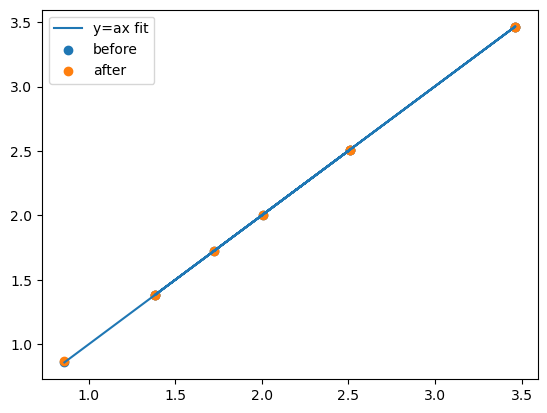

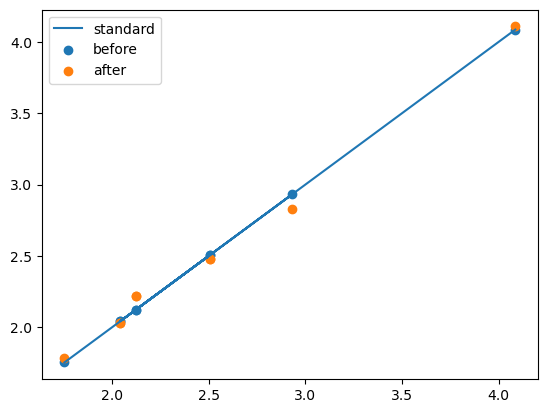

In [5]:
#Confirm
import matplotlib.pyplot as plt

new_params_0['k']=(new_params_0['k']+new_params_0['k'].T)/2
params_star['k']=(params_star['k']+params_star['k'].T)/2
params_0_old['k']=(params_0_old['k']+params_0_old['k'].T)/2

a=torch.sum(new_params_0['k'][1:,1:].reshape(-1))/torch.sum(params_star['k'][1:,1:].reshape(-1))
plt.plot(params_star['k'][1:,1:].reshape(-1),a*params_star['k'][1:,1:].reshape(-1),label='y=ax fit')
plt.scatter(params_star['k'][1:,1:].reshape(-1),params_0_old['k'][1:,1:].reshape(-1),label='before')
plt.scatter(params_star['k'][1:,1:].reshape(-1),new_params_0['k'][1:,1:].reshape(-1),label='after')
plt.legend()
plt.show()

#Compare
import matplotlib.pyplot as plt

plt.plot(params_star['r0'][1:,1:].reshape(-1),params_star['r0'][1:,1:].reshape(-1),label='standard')
plt.scatter(params_star['r0'][1:,1:].reshape(-1),params_0_old['r0'][1:,1:].reshape(-1),label='before')
plt.scatter(params_star['r0'][1:,1:].reshape(-1),new_params_0['r0'][1:,1:].reshape(-1),label='after')
plt.legend()
plt.show()

In [6]:
#Energy landscape opt

params_0 OrderedDict([('k', tensor([[4.1151, 1.6827, 1.0212, 1.6493],
        [1.6827, 0.8589, 3.4642, 1.3827],
        [1.0212, 3.4642, 2.0062, 2.5053],
        [1.6493, 1.3827, 2.5053, 1.7240]], dtype=torch.float64)), ('r0', tensor([[3.5824, 1.0934, 2.5985, 3.9278],
        [1.0934, 1.7544, 2.1228, 2.5091],
        [2.5985, 2.1228, 2.9334, 2.0435],
        [3.9278, 2.5091, 2.0435, 4.0866]], dtype=torch.float64))])
loss: 0.9774890552684389
0.9774890552684389


  0%|          | 0/10001 [00:00<?, ?it/s]

0 65.28096880143332 tensor(0.0077, dtype=torch.float64, grad_fn=<DivBackward0>) tensor(0.0631, dtype=torch.float64, grad_fn=<AddBackward0>)


/Users/soonhyun/Desktop/GeometryOptimization/Landscape_Fork/GeoMatry_LandscapeBased/GeoMatry_LandscapeBased/demo/../geomatry/opt_Energy_approximated/optimizer.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deviations = torch.tensor(deviations_magnitude,device=self.device,requires_grad=False).float().reshape(eN)


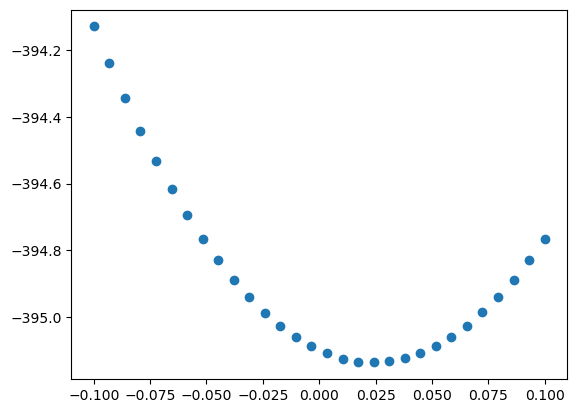

100%|█████████▉| 9998/10001 [00:37<00:00, 271.49it/s]

10000 67.01279133548641 tensor(0.0075, dtype=torch.float64, grad_fn=<DivBackward0>) tensor(0.0583, dtype=torch.float64, grad_fn=<AddBackward0>)


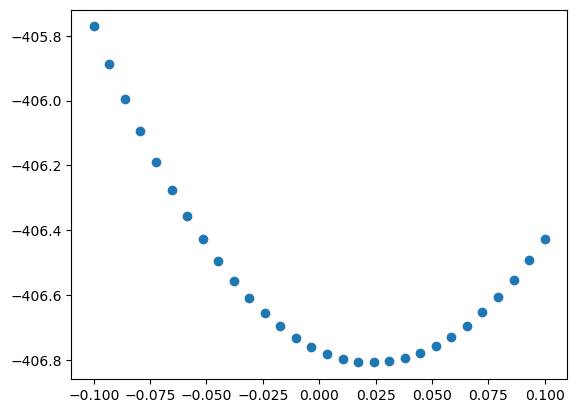

100%|██████████| 10001/10001 [00:37<00:00, 267.82it/s]

final OrderedDict([('k', tensor([[4.1151, 1.6827, 1.0212, 1.6493],
        [1.6827, 0.8494, 3.5184, 1.5092],
        [1.0212, 3.5184, 2.0269, 2.7288],
        [1.6493, 1.5092, 2.7288, 1.1109]], dtype=torch.float64)), ('r0', tensor([[3.5824, 1.0934, 2.5985, 3.9278],
        [1.0934, 1.7522, 2.1232, 2.5059],
        [2.5985, 2.1232, 2.9310, 2.0431],
        [3.9278, 2.5059, 2.0431, 4.1614]], dtype=torch.float64))])


In [7]:
def energyAndRsquare(k_perturbed, r0_perturbed, optimizer):
    ff.reset_parameters(k_perturbed, r0_perturbed)
    params_0 = ff.state_dict()
    print("params_0", params_0)
    for i in range(1):
        params_0=optimizer.optimize(params_0, 10001, 10000, 0.1, 6, 2)
    return params_0
new_params_0_Energy=energyAndRsquare(k_perturbed, r0_perturbed, optimizer_Energy)


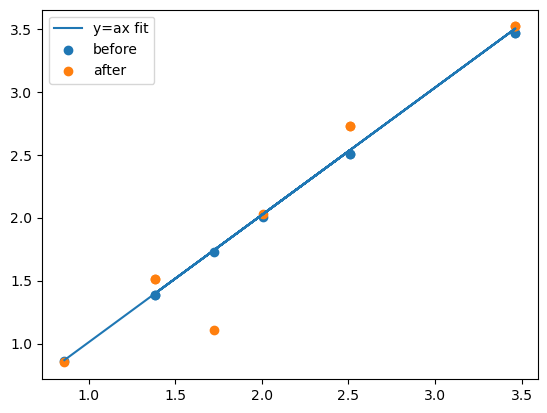

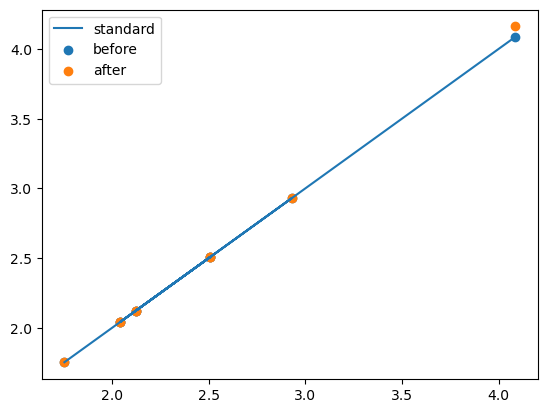

In [8]:
#Confirm
import matplotlib.pyplot as plt

new_params_0_Energy['k']=(new_params_0_Energy['k']+new_params_0_Energy['k'].T)/2
params_star['k']=(params_star['k']+params_star['k'].T)/2
params_0_old['k']=(params_0_old['k']+params_0_old['k'].T)/2

a=torch.sum(new_params_0_Energy['k'][1:,1:].reshape(-1))/torch.sum(params_star['k'][1:,1:].reshape(-1))
plt.plot(params_star['k'][1:,1:].reshape(-1),a*params_star['k'][1:,1:].reshape(-1),label='y=ax fit')
plt.scatter(params_star['k'][1:,1:].reshape(-1),params_0_old['k'][1:,1:].reshape(-1),label='before')
plt.scatter(params_star['k'][1:,1:].reshape(-1),new_params_0_Energy['k'][1:,1:].reshape(-1),label='after')
plt.legend()
plt.show()

#Compare
import matplotlib.pyplot as plt

plt.plot(params_star['r0'][1:,1:].reshape(-1),params_star['r0'][1:,1:].reshape(-1),label='standard')
plt.scatter(params_star['r0'][1:,1:].reshape(-1),params_0_old['r0'][1:,1:].reshape(-1),label='before')
plt.scatter(params_star['r0'][1:,1:].reshape(-1),new_params_0_Energy['r0'][1:,1:].reshape(-1),label='after')
plt.legend()
plt.show()